In [1]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sqlalchemy import create_engine


In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
project_path = config["PATH"]["project"]
os.chdir(project_path)

Create spark session. Add driver postgress to enable to load from existing postgres DB


In [4]:
# add driver postgress to enable to load from existing postgres DB
spark = SparkSession \
    .builder \
    .appName("US_weather") \
    .config("spark.jars", "postgresql-42.2.18.jar")\
    .config( "spark.driver.extraClassPath", "postgresql-42.2.18.jar")\
    .getOrCreate()

Connect to postgres; read stations table from postgres DB "covid"

# Load data

## Read US stations from sql DB (including unincorporated territories)

In [5]:
# Puerto Rico, Virgin Islands, Guam, Samoa
unincorporated_territories = ["RQ", "VQ", "CQ", "AQ"]
US_territories = unincorporated_territories[:]
US_territories.append("US")

In [6]:
%%time
# Load weather stations for the whole world
engine = create_engine('postgresql://sb:sb@localhost:5432/covid')
world_stations = pd.read_sql_table("world_stations", engine)

CPU times: user 504 ms, sys: 56.5 ms, total: 560 ms
Wall time: 1.14 s


In [7]:
world_stations

,station_id,latitude,longitude,elevation,state,station_name
0,ACW00011604,17.1167,-61.7833,10.1,,ST JOHNS COOLIDGE FLD
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS
2,AE000041196,25.3330,55.5170,34.0,,SHARJAH INTER. AIRP GSN 41196
3,AEM00041194,25.2550,55.3640,10.4,,DUBAI INTL 41194
4,AEM00041217,24.4330,54.6510,26.8,,ABU DHABI INTL 41217
...,...,...,...,...,...,...
118487,ZI000067969,21.0500,29.3670,861.0,,WEST NICHOLSON 67969
118488,ZI000067975,20.0670,30.8670,1095.0,,MASVINGO 67975
118489,ZI000067977,21.0170,31.5830,430.0,,BUFFALO RANGE 67977
118490,ZI000067983,20.2000,32.6160,1132.0,,CHIPINGE GSN 67983


In [8]:
US_stations = world_stations[ world_stations["station_id"].str[0:2].isin(US_territories) ].copy()
US_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65478 entries, 225 to 118159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_id    65478 non-null  object 
 1   latitude      65478 non-null  float64
 2   longitude     65478 non-null  float64
 3   elevation     65478 non-null  float64
 4   state         65478 non-null  object 
 5   station_name  65478 non-null  object 
dtypes: float64(3), object(3)
memory usage: 3.5+ MB


## Load filtered US weather stations

Only the stations yielding a valid measurement almost each day of 2020 are loaded.

In [9]:
df_filtered_stations = pd.read_csv("significant_stations.csv", index_col = 0)

In [10]:
df_filtered_stations.head()

,station_id,measured,nb_days
0,US1MDHW0007,PRCP,366
1,US1MNSE0002,PRCP,366
2,USW00014820,TAVG,366
3,USR0000CROC,TMIN,366
4,USC00132638,SNOW,355


In [11]:
df_filtered_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32814 entries, 0 to 32813
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   station_id  32814 non-null  object
 1   measured    32814 non-null  object
 2   nb_days     32814 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


# Find closest station to fips

In [12]:
def precompute_distance(l_ref):
    ''' 
    convert latitude and longitude to radian, and compute cos(latitude),
    which is necessary to compute the distance between any two GPS coordinates
    '''
    l_ref.rename(columns = {"latitude" : "latitude_degrees",
                           "longitude" : "longitude_degrees"
                          },
                inplace= True)
    def degree_to_radian(x):
        return  float(x)* np.pi / 180.
    l_ref["latitude_rad"] = l_ref["latitude_degrees"].apply( degree_to_radian) 
    l_ref["longitude_rad"] = l_ref["longitude_degrees"].apply( degree_to_radian)
    l_ref["cos_latitude"] = np.cos(l_ref["latitude_rad"])            

In [13]:
precompute_distance(US_stations)

For each element, list of the stations which give the element

In [14]:
l_measurements= ["SNOW", "SNWD", "PRCP", "TMAX", "TMIN", "TAVG"]

In [15]:
d_stations_per_element = {}
for element in l_measurements:
    d_stations_per_element[element] = pd.merge(
        df_filtered_stations[ df_filtered_stations["measured"] == element],
        US_stations, on = "station_id")\
        [ ["station_id", "latitude_rad", "longitude_rad", "cos_latitude"]].drop_duplicates()

In [16]:
for element, lst in d_stations_per_element.items():
    print(element, len(lst))

SNOW 3505
SNWD 3931
PRCP 11740
TMAX 5730
TMIN 5686
TAVG 2222


In [17]:
d_stations_per_element["TMAX"].head()

,station_id,latitude_rad,longitude_rad,cos_latitude
0,USW00024048,0.776966,-1.886390,0.713044
1,USW00094274,0.824974,-2.139357,0.678576
2,USS0005K27S,0.692198,-1.842893,0.769845
3,USS0045L01S,1.056797,-2.543817,0.491664
4,USC00339220,0.688038,-1.462973,0.772493


## US counties geographic info from Gazeeter

In [18]:
def counties_lat_long_(name):
    with open(name) as f :
        headers = f.readline().split()
        l_headers = len(headers)
        print("len of headers : ", l_headers )
        l_res = []
        for line in f :
            l_str = line.split()
            state = l_str[0]
            fips = l_str[1]
            latitude = l_str[-2]
            longitude = l_str[-1]
            l = len(l_str)
            n_words = l - l_headers + 1
            county = " ".join( l_str[3:3+n_words] )
            #d_res.setdefault(state, []).append( [ state, county, fips, latitude, longitude ])
            l_res.append( [state, county, fips, latitude, longitude ])
        return l_res


In [19]:
def counties_lat_long(name):
    l_gazeeter = counties_lat_long_(name)
    df_gazeeter = pd.DataFrame(l_gazeeter, columns = ["state", "county", "fips", "latitude", "longitude"])
    return df_gazeeter

In [20]:
data_root = os.path.join(project_path, 'DATA/')

In [21]:
gazeeter_counties= counties_lat_long( os.path.join(data_root,"2020_Gaz_counties_national.txt"))
print("number of counties from Gazeeter : ", len(gazeeter_counties))

len of headers :  10
number of counties from Gazeeter :  3221


In [22]:
precompute_distance(gazeeter_counties)

In [23]:
gazeeter_counties.head()

,state,county,fips,latitude_degrees,longitude_degrees,latitude_rad,longitude_rad,cos_latitude
0,AL,Autauga County,01001,32.532237,-86.64644,0.567795,-1.512266,0.843089
1,AL,Baldwin County,01003,30.659218,-87.746067,0.535104,-1.531458,0.860215
2,AL,Barbour County,01005,31.870253,-85.405104,0.556241,-1.490600,0.849246
3,AL,Bibb County,01007,33.015893,-87.127148,0.576236,-1.520656,0.838519
4,AL,Blount County,01009,33.977358,-86.56644,0.593017,-1.510869,0.829258


In [24]:
def closest_ref(l_ref, latitude, longitude, cos_latitude):
        ''' computation of angular distance between 2 locations given by GPS coordinates
        exact formulas (maybe overkill), taken from :
        https://www.movable-type.co.uk/scripts/latlong.html
        '''    
        # Haversine formula
        #print(l_ref.head())
        l_ref["delta_lat_term"] = ( np.sin( (l_ref["latitude_rad"] - latitude) * 0.5 ) )**2
        l_ref["delta_long_term"] = ( np.sin( (l_ref["longitude_rad"] - longitude) * 0.5) )**2
        l_ref["a"] = l_ref["delta_lat_term"] + l_ref["delta_long_term"] \
                        * cos_latitude * l_ref["cos_latitude"]
        l_ref["sqrt_a"] = l_ref["a"].apply( lambda x : np.sqrt(x) )
        l_ref["sqrt_1_a"] = l_ref["a"].apply(lambda x : np.sqrt(1.- x) )
        l_ref["angle"] = np.arctan2( np.sqrt(l_ref["a"]), np.sqrt( 1. - l_ref["a"] ) )
        closest = l_ref["angle"].idxmin()
        #print(closest)
        return closest, l_ref.iloc[closest]

In [25]:
import functools

In [26]:
def func_closest_station( df_row, df_stations):
    i, res = closest_ref( df_stations, df_row["latitude_rad"], df_row["longitude_rad"], df_row["cos_latitude"] )
    return res.loc[["station_id", "latitude_rad", "longitude_rad", "angle"]]

In [27]:
R_earth = 6371

!! approximately 11 min to complete

In [68]:
closeststation_per_element ={}
for element in l_measurements:
    element_function = functools.partial(func_closest_station, df_stations=d_stations_per_element[element])
    %time res = gazeeter_counties.apply(element_function, axis = 1)
    res["distance"] = R_earth * res["angle"]
    closeststation_per_element[element] = pd.concat( [ res, gazeeter_counties[ ["fips", "state", "county"] ]], axis = 1)


CPU times: user 1min 23s, sys: 110 ms, total: 1min 23s
Wall time: 1min 23s
CPU times: user 1min 58s, sys: 603 ms, total: 1min 59s
Wall time: 1min 59s
CPU times: user 3min 49s, sys: 519 ms, total: 3min 49s
Wall time: 3min 50s
CPU times: user 1min 54s, sys: 152 ms, total: 1min 54s
Wall time: 1min 54s
CPU times: user 1min 54s, sys: 656 ms, total: 1min 55s
Wall time: 1min 55s
CPU times: user 58.3 s, sys: 412 ms, total: 58.7 s
Wall time: 58.7 s


## Checks

In [87]:
closeststation_per_element["PRCP"].head()

,station_id,latitude_rad,longitude_rad,angle,distance,fips,state,county
0,USC00010823,0.570068,-1.513626,0.001273,8.110800,01001,AL,Autauga County
1,US1ALBW0079,0.533589,-1.533174,0.001058,6.740569,01003,AL,Baldwin County
2,US1ALBR0006,0.556456,-1.493721,0.001329,8.469317,01005,AL,Barbour County
3,USC00011100,0.576618,-1.518475,0.000934,5.950284,01007,AL,Bibb County
4,USC00016121,0.592127,-1.508333,0.001142,7.277017,01009,AL,Blount County


In [88]:
for e, l  in closeststation_per_element.items():
    #print(e, len(l), l["distance"].min(), l["distance"].max(), l["distance"].mean())
    print(e, len(l), l["distance"].describe())

SNOW 3221 count    3221.000000
mean       36.269465
std       145.481718
min         0.034007
25%         4.994360
50%        10.515585
75%        18.526782
max      1883.043157
Name: distance, dtype: float64
SNWD 3221 count    3221.000000
mean       37.063905
std       146.487759
min         0.034007
25%         5.124577
50%        10.684539
75%        18.826863
max      1883.043157
Name: distance, dtype: float64
PRCP 3221 count    3221.000000
mean        6.950718
std        10.202384
min         0.034007
25%         2.731558
50%         5.003718
75%         9.159941
max       467.782916
Name: distance, dtype: float64
TMAX 3221 count    3221.000000
mean        9.336016
std        10.562757
min         0.034007
25%         3.881924
50%         7.492909
75%        13.087703
max       467.782916
Name: distance, dtype: float64
TMIN 3221 count    3221.000000
mean        9.379134
std        10.566624
min         0.034007
25%         3.924246
50%         7.608496
75%        13.115347
max    

## Output

In [76]:
closest_stations_allinfo ={} 
for element, l_stations in closeststation_per_element.items():
    closest_stations_allinfo[element] = pd.merge( l_stations, US_stations, on = "station_id")\
        .rename(columns = { "latitude_degrees" : "latitude_station", "longitude_degrees" : "longitude_station", 
                          "state_x" : "state_gazeeter", "state_y" : "state_station"})\
        [ ["fips",  "county", "state_gazeeter", 
           "station_id", "station_name", "state_station", "latitude_station", "longitude_station", "distance" ] ]

In [77]:
for element, l_stations in closest_stations_allinfo.items():
    out_name = os.path.join("OUT_DATA", f"closest_for_{element}.csv")
    l_stations.to_csv(out_name)
                    

In [78]:
# convert to multi index
dfmi_closest_stations = pd.concat(closest_stations_allinfo.values(), keys = closeststation_per_element.keys())

In [79]:
dfmi_closest_stations

fips                  county state_gazeeter   station_id  \
SNOW 0     01001          Autauga County             AL  USW00013895   
     1     01047           Dallas County             AL  USW00013895   
     2     01051           Elmore County             AL  USW00013895   
     3     01085          Lowndes County             AL  USW00013895   
     4     01003          Baldwin County             AL  USW00013838   
...          ...                     ...            ...          ...   
TAVG 3216  72133  Santa Isabel Municipio             PR  USW00012839   
     3217  72141        Utuado Municipio             PR  USW00012839   
     3218  72149      Villalba Municipio             PR  USW00012839   
     3219  72151       Yabucoa Municipio             PR  USW00012839   
     3220  72153         Yauco Municipio             PR  USW00012839   

                                           station_name state_station  \
SNOW 0     MONTGOMERY AP                          72226            AL   
     1     MONTGOMERY AP                          72226            AL   
     2     MONTGOMERY AP                          72226            AL   
     3     MONTGOMERY AP                          72226            AL   
     4     MOBILE DWTN AP                                          AL   
...                                                 ...           ...   
TAVG 3216  MIAMI INTL AP                          72202            FL   
     3217  MIAMI INTL AP                          72202            FL   
     3218  MIAMI INTL AP                          72202            FL   
     3219  MIAMI INTL AP                          72202            FL   
     3220  MIAMI INTL AP                          72202            FL   

           latitude_station  longitude_station    distance  
SNOW 0              32.2997           -86.4075   17.114579  
     1              32.2997           -86.4075   33.265523  
     2              32.2997           -86.4075   20.686701  
     3              32.2997           -86.4075   14.211241  
     4              30.6264           -88.0681   15.511778  
...                     ...                ...         ...  
TAVG 3216           25.7906           -80.3164  839.529466  
     3217           25.7906           -80.3164  815.878703  
     3218           25.7906           -80.3164  830.342695  
     3219           25.7906           -80.3164  859.654377  
     3220           25.7906           -80.3164  814.772073  

[19326 rows x 9 columns]

In [28]:
out_name = os.path.join("OUT_DATA", "closest_stations.csv")closest_stations_allinfo = titi


In [81]:
dfmi_closest_stations.to_csv(out_name)

In [171]:
# check multi index read ok 
toto = pd.read_csv(out_name, index_col = [0,1])#, skipinitialspace=True)
toto

fips                  county state_gazeeter   station_id  \
SNOW 0      1001          Autauga County             AL  USW00013895   
     1      1047           Dallas County             AL  USW00013895   
     2      1051           Elmore County             AL  USW00013895   
     3      1085          Lowndes County             AL  USW00013895   
     4      1003          Baldwin County             AL  USW00013838   
...          ...                     ...            ...          ...   
TAVG 3216  72133  Santa Isabel Municipio             PR  USW00012839   
     3217  72141        Utuado Municipio             PR  USW00012839   
     3218  72149      Villalba Municipio             PR  USW00012839   
     3219  72151       Yabucoa Municipio             PR  USW00012839   
     3220  72153         Yauco Municipio             PR  USW00012839   

                                           station_name state_station  \
SNOW 0     MONTGOMERY AP                          72226            AL   
     1     MONTGOMERY AP                          72226            AL   
     2     MONTGOMERY AP                          72226            AL   
     3     MONTGOMERY AP                          72226            AL   
     4     MOBILE DWTN AP                                          AL   
...                                                 ...           ...   
TAVG 3216  MIAMI INTL AP                          72202            FL   
     3217  MIAMI INTL AP                          72202            FL   
     3218  MIAMI INTL AP                          72202            FL   
     3219  MIAMI INTL AP                          72202            FL   
     3220  MIAMI INTL AP                          72202            FL   

           latitude_station  longitude_station    distance  
SNOW 0              32.2997           -86.4075   17.114579  
     1              32.2997           -86.4075   33.265523  
     2              32.2997           -86.4075   20.686701  
     3              32.2997           -86.4075   14.211241  
     4              30.6264           -88.0681   15.511778  
...                     ...                ...         ...  
TAVG 3216           25.7906           -80.3164  839.529466  
     3217           25.7906           -80.3164  815.878703  
     3218           25.7906           -80.3164  830.342695  
     3219           25.7906           -80.3164  859.654377  
     3220           25.7906           -80.3164  814.772073  

[19326 rows x 9 columns]

In [172]:
#titi = toto.groupby(level=0).apply(lambda toto: toto.xs(toto.name).to_dict()).to_dict()
# convert multiindex dataframe to dict

# all level 0 index values (i.e. weather elements)
l_weather_elements = toto.index.levels[0]
print(l_weather_elements)
# slice dataframe along elements and make put into dict

titi= { elem : toto.xs(elem) for elem in l_weather_elements }
titi["PRCP"].head()


Index(['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], dtype='object')


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
0,1001,Autauga County,AL,USC00010823,BILLINGSLEY,AL,32.6625,-86.7244,8.110800
1,1003,Baldwin County,AL,US1ALBW0079,DAPHNE 4.9 SE,AL,30.5724,-87.8444,6.740569
2,1005,Barbour County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,8.469317
3,1011,Bullock County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,13.711696
4,1109,Pike County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,17.527742


# Handle outliers

Identify fips which have been attributed to a wrong station.

In [173]:
dfmi_closest_stations = toto
closest_stations_allinfo = titi

<AxesSubplot:>

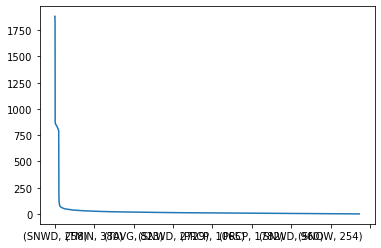

In [31]:
dfmi_closest_stations["distance"].sort_values(ascending = False).plot()

<AxesSubplot:>

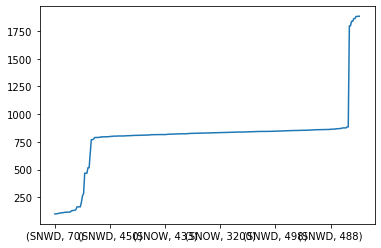

In [32]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 100]["distance"].sort_values().plot()

<AxesSubplot:>

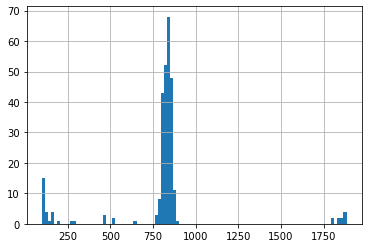

In [33]:
dfmi_closest_stations["distance"].where(dfmi_closest_stations["distance"]>100).hist(bins = 100)

<AxesSubplot:>

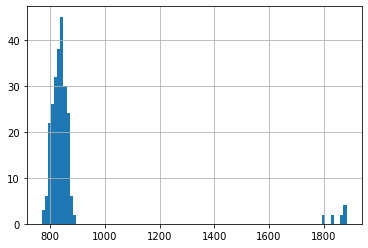

In [34]:
stations_further_700 = dfmi_closest_stations[ dfmi_closest_stations["distance"]> 700]
stations_further_700["distance"].hist(bins = 100)

In [35]:
stations_further_700.describe()

,fips,latitude_station,longitude_station,distance
count,244.000000,244.000000,244.000000,244.000000
mean,69737.700820,26.547426,-83.246346,874.241271
std,11337.933657,4.633395,14.293297,203.818560
min,15001.000000,24.725800,-166.543300,770.309777
25%,72034.500000,25.790600,-81.051700,815.985679
50%,72073.000000,25.790600,-80.316400,835.458343
75%,72113.000000,26.071900,-80.197900,852.216386
max,72153.000000,53.895000,-80.153600,1883.043157


In [36]:
stations_further_700[["state_gazeeter", "state_station"]]

state_gazeeter state_station
SNOW 95               HI            AK
     96               HI            AK
     97               HI            AK
     262              HI            CA
     263              HI            CA
...                  ...           ...
TAVG 3216             PR            FL
     3217             PR            FL
     3218             PR            FL
     3219             PR            FL
     3220             PR            FL

[244 rows x 2 columns]

In [37]:
stations_further_700["state_gazeeter"].value_counts()

PR    234
HI     10
Name: state_gazeeter, dtype: int64

In [38]:
stations_further_700["state_station"].value_counts()

FL    234
AK      6
CA      4
Name: state_station, dtype: int64

FIPS from Hawai and Puerto Rico are incorrectly matched because the list of stations with USxxx prefix does not contain unincorporated territories

In [39]:
gazeeter_counties[ gazeeter_counties["state"] == "HI"]

,state,county,fips,latitude_degrees,longitude_degrees,latitude_rad,longitude_rad,cos_latitude
547,HI,Hawaii County,15001,19.597764,-155.502443,0.342046,-2.714030,0.942071
548,HI,Honolulu County,15003,21.461365,-158.201974,0.374571,-2.761145,0.930664
549,HI,Kalawao County,15005,21.218764,-156.97401,0.370337,-2.739713,0.932205
550,HI,Kauai County,15007,22.012038,-159.705965,0.384183,-2.787395,0.927105
551,HI,Maui County,15009,20.855931,-156.60155,0.364005,-2.733213,0.934479


In [40]:
world_stations = pd.read_csv("DATA/WEATHER/ghcnd-stations_noname.txt", delim_whitespace = True, names = ["id", "latitude", "longitude", "elevation"])

In [41]:
world_stations.columns

Index(['id', 'latitude', 'longitude', 'elevation'], dtype='object')

In [42]:
world_stations.describe()

,latitude,longitude,elevation
count,118492.000000,118492.000000,118492.000000
mean,24.925502,-41.351049,449.471609
std,28.963270,91.205526,663.975681
min,-90.000000,-179.983000,-999.900000
25%,19.316700,-100.684350,84.000000
50%,36.505300,-84.079550,258.800000
75%,42.792200,11.517300,610.000000
max,83.650000,179.320000,5033.000000


In [43]:
hawai_longitude = ( -160.5, -154)
hawai_latitude = ( 18, 22.5)

In [44]:
stations_long_hawai = world_stations[ ( world_stations["longitude"]>-160.5 ) & ( world_stations["longitude"]< -154 )
                                    & ( world_stations["latitude"]>18 ) & ( world_stations["latitude"]< 22.5 ) ]

In [45]:
sorted( list(stations_long_hawai["id"]) )

['US1HIHI0001',
 'US1HIHI0002',
 'US1HIHI0003',
 'US1HIHI0004',
 'US1HIHI0006',
 'US1HIHI0008',
 'US1HIHI0010',
 'US1HIHI0011',
 'US1HIHI0012',
 'US1HIHI0013',
 'US1HIHI0014',
 'US1HIHI0015',
 'US1HIHI0016',
 'US1HIHI0017',
 'US1HIHI0019',
 'US1HIHI0020',
 'US1HIHI0021',
 'US1HIHI0022',
 'US1HIHI0024',
 'US1HIHI0026',
 'US1HIHI0031',
 'US1HIHI0033',
 'US1HIHI0034',
 'US1HIHI0035',
 'US1HIHI0036',
 'US1HIHI0037',
 'US1HIHI0038',
 'US1HIHI0039',
 'US1HIHI0040',
 'US1HIHI0041',
 'US1HIHI0042',
 'US1HIHI0043',
 'US1HIHI0045',
 'US1HIHI0047',
 'US1HIHI0049',
 'US1HIHI0050',
 'US1HIHI0051',
 'US1HIHI0052',
 'US1HIHI0053',
 'US1HIHI0055',
 'US1HIHI0056',
 'US1HIHI0057',
 'US1HIHI0059',
 'US1HIHI0060',
 'US1HIHI0065',
 'US1HIHI0066',
 'US1HIHI0067',
 'US1HIHI0068',
 'US1HIHI0070',
 'US1HIHI0071',
 'US1HIHI0072',
 'US1HIHI0074',
 'US1HIHI0079',
 'US1HIHI0080',
 'US1HIHI0081',
 'US1HIHI0082',
 'US1HIHI0083',
 'US1HIHI0084',
 'US1HIHI0086',
 'US1HIHI0087',
 'US1HIHI0088',
 'US1HIHN0002',
 'US1HIH

In [46]:
df_stations[ df_stations["station_id"] == "USW00022551" ]
#USR0000HKMO

NameError: name 'df_stations' is not defined

In [47]:
gazeeter_counties[ gazeeter_counties["state"] == "HI"]

,state,county,fips,latitude_degrees,longitude_degrees,latitude_rad,longitude_rad,cos_latitude
547,HI,Hawaii County,15001,19.597764,-155.502443,0.342046,-2.714030,0.942071
548,HI,Honolulu County,15003,21.461365,-158.201974,0.374571,-2.761145,0.930664
549,HI,Kalawao County,15005,21.218764,-156.97401,0.370337,-2.739713,0.932205
550,HI,Kauai County,15007,22.012038,-159.705965,0.384183,-2.787395,0.927105
551,HI,Maui County,15009,20.855931,-156.60155,0.364005,-2.733213,0.934479


In [48]:
stt = "USR0000HKMO"
df_stations[ df_stations["station_id"] == stt]

NameError: name 'df_stations' is not defined

In [49]:
stations_selected = pd.read_parquet("OUT_DATA/stations_selected-measures_ndays")

In [50]:
stations_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81991 entries, 0 to 81990
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   station_id  81991 non-null  object
 1   measured    81991 non-null  object
 2   nb_days     81991 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [51]:
stations_selected_hawaii = stations_selected[ stations_selected["station_id"].isin(list(stations_long_hawai["id"]) ) ]

In [52]:
stations_selected_hawaii

,station_id,measured,nb_days
71,USC00516928,PRCP,356
206,USC00513977,TMIN,145
227,USR0000HMLK,TMIN,366
334,USC00510470,TMIN,55
397,US1HIKI0019,PRCP,356
...,...,...,...
80952,USR0000HMAH,TMAX,366
80976,USC00516128,TMAX,361
81143,US1HIHN0027,SNOW,73
81298,USR0000HMAR,TMAX,355


In [53]:
stations_long_hawai.shape

(749, 4)

In [54]:
stations_selected_hawaii[ stations_selected_hawaii["nb_days"]>350]

,station_id,measured,nb_days
71,USC00516928,PRCP,356
227,USR0000HMLK,TMIN,366
397,US1HIKI0019,PRCP,356
1275,USW00021504,TAVG,366
1706,USR0000HPTA,TAVG,366
...,...,...,...
79441,USC00519523,TMIN,351
79810,USW00022516,TAVG,366
80952,USR0000HMAH,TMAX,366
80976,USC00516128,TMAX,361


In [55]:
df_filtered_stations[ df_filtered_stations["station_id"].isin(list(stations_long_hawai["id"]) )]

,station_id,measured,nb_days
38,USC00516928,PRCP,356
125,USR0000HMLK,TMIN,366
166,US1HIKI0019,PRCP,356
535,USW00021504,TAVG,366
729,USR0000HPTA,TAVG,366
...,...,...,...
31784,USC00519523,TMIN,351
31961,USW00022516,TAVG,366
32397,USR0000HMAH,TMAX,366
32415,USC00516128,TMAX,361


In [56]:
stations_selected_hawaii[ stations_selected_hawaii["nb_days"]>350].equals( df_filtered_stations[ df_filtered_stations["station_id"].isin(list(stations_long_hawai["id"]) )] )

False

In [57]:
stations_further_700[ stations_further_700["state_gazeeter"] == "HI"]

fips           county state_gazeeter   station_id  \
SNOW 95   15003  Honolulu County             HI  USC00502587   
     96   15005   Kalawao County             HI  USC00502587   
     97   15007     Kauai County             HI  USC00502587   
     262  15001    Hawaii County             HI  US1CASM0007   
     263  15009      Maui County             HI  US1CASM0007   
SNWD 91   15003  Honolulu County             HI  USC00502587   
     92   15005   Kalawao County             HI  USC00502587   
     93   15007     Kauai County             HI  USC00502587   
     257  15001    Hawaii County             HI  US1CASM0007   
     258  15009      Maui County             HI  US1CASM0007   

                                          station_name state_station  \
SNOW 95   DUTCH HARBOR                                            AK   
     96   DUTCH HARBOR                                            AK   
     97   DUTCH HARBOR                                            AK   
     262  HALF MOON BAY 0.5 SSW                                   CA   
     263  HALF MOON BAY 0.5 SSW                                   CA   
SNWD 91   DUTCH HARBOR                                            AK   
     92   DUTCH HARBOR                                            AK   
     93   DUTCH HARBOR                                            AK   
     257  HALF MOON BAY 0.5 SSW                                   CA   
     258  HALF MOON BAY 0.5 SSW                                   CA   

          latitude_station  longitude_station     distance  
SNOW 95             53.895          -166.5433  1837.397653  
     96             53.895          -166.5433  1861.329474  
     97             53.895          -166.5433  1795.907377  
     262            37.463          -122.4408  1880.790043  
     263            37.463          -122.4408  1883.043157  
SNWD 91             53.895          -166.5433  1837.397653  
     92             53.895          -166.5433  1861.329474  
     93             53.895          -166.5433  1795.907377  
     257            37.463          -122.4408  1880.790043  
     258            37.463          -122.4408  1883.043157

<font size=5>**Conclusion : No snow in Hawaii !! ;)**</font>

In [58]:
stations_further_700[ stations_further_700["state_gazeeter"] == "PR"]

fips                  county state_gazeeter   station_id  \
SNOW 425   72001      Adjuntas Municipio             PR  USW00012839   
     426   72003        Aguada Municipio             PR  USW00012839   
     427   72005     Aguadilla Municipio             PR  USW00012839   
     428   72007  Aguas Buenas Municipio             PR  USW00012839   
     429   72009      Aibonito Municipio             PR  USW00012839   
...          ...                     ...            ...          ...   
TAVG 3216  72133  Santa Isabel Municipio             PR  USW00012839   
     3217  72141        Utuado Municipio             PR  USW00012839   
     3218  72149      Villalba Municipio             PR  USW00012839   
     3219  72151       Yabucoa Municipio             PR  USW00012839   
     3220  72153         Yauco Municipio             PR  USW00012839   

                                           station_name state_station  \
SNOW 425   MIAMI INTL AP                          72202            FL   
     426   MIAMI INTL AP                          72202            FL   
     427   MIAMI INTL AP                          72202            FL   
     428   MIAMI INTL AP                          72202            FL   
     429   MIAMI INTL AP                          72202            FL   
...                                                 ...           ...   
TAVG 3216  MIAMI INTL AP                          72202            FL   
     3217  MIAMI INTL AP                          72202            FL   
     3218  MIAMI INTL AP                          72202            FL   
     3219  MIAMI INTL AP                          72202            FL   
     3220  MIAMI INTL AP                          72202            FL   

           latitude_station  longitude_station    distance  
SNOW 425            25.7906           -80.3164  816.178941  
     426            25.7906           -80.3164  791.410175  
     427            25.7906           -80.3164  790.049157  
     428            25.7906           -80.3164  841.812683  
     429            25.7906           -80.3164  839.538138  
...                     ...                ...         ...  
TAVG 3216           25.7906           -80.3164  839.529466  
     3217           25.7906           -80.3164  815.878703  
     3218           25.7906           -80.3164  830.342695  
     3219           25.7906           -80.3164  859.654377  
     3220           25.7906           -80.3164  814.772073  

[234 rows x 9 columns]

In [59]:
dfmi_closest_stations[dfmi_closest_stations["state_gazeeter"] == "PR"]["distance"].describe()

count    468.000000
mean     419.798072
std      413.446163
min        0.146478
25%        5.988331
50%      406.108779
75%      835.211650
max      885.650469
Name: distance, dtype: float64

In [60]:
stations_further_700[ stations_further_700["state_gazeeter"] == "PR"]["state_station"].value_counts()

FL    234
Name: state_station, dtype: int64

<font size=5>**Puerto Rico fips always maps to stations in Florida**</font>

In [65]:
a = df_stations[df_stations["station_id"].str.startswith("US")]
print(len(a), len(df_stations))

65170 65170


## Outliers in precipitations

In [92]:
closest_stations_allinfo["PRCP"].describe()

,fips,latitude_station,longitude_station,distance
count,3221.000000,3221.000000,3221.000000,3221.000000
mean,31384.438684,37.972892,-91.675968,6.950718
std,16297.853531,6.108858,13.420304,10.202384
min,1001.000000,18.028100,-170.211900,0.034007
25%,19031.000000,34.332500,-98.108600,2.731558
50%,30023.000000,38.214400,-89.968100,5.003718
75%,46105.000000,41.706900,-82.969700,9.159941
max,72153.000000,70.346400,-65.290000,467.782916


In [93]:
closest_stations_allinfo["PRCP"].sort_values(by = "distance", ascending= False).head(10)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
76,2016,Aleutians West Census Area,AK,USW00025711,ST. PAUL 4 NE 70309,AK,57.1575,-170.2119,467.782916
79,2158,Kusilvak Census Area,AK,USW00026615,BETHEL AP GSN 70219,AK,60.7850,-161.8292,90.783556
95,2185,North Slope Borough,AK,USC00500235,ALPINE,AK,70.3464,-150.9283,69.642501
81,2070,Dillingham Census Area,AK,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
96,2188,Northwest Arctic Borough,AK,USW00026616,KOTZEBUE RALPH WEIN AP GSN 70133,AK,66.8667,-162.6333,57.409746
97,2195,Petersburg Borough,AK,USC00503605,HIDDEN FALLS HATCHERY,AK,57.2178,-134.8770,56.626781
78,2050,Bethel Census Area,AK,USW00026615,BETHEL AP GSN 70219,AK,60.7850,-161.8292,46.094564
1166,22075,Plaquemines Parish,LA,US1LAOR0013,WESTWEGO 2.4 ENE,LA,29.9209,-90.1070,43.803054
1776,32031,Washoe County,NV,USC00267953,SUTCLIFFE,NV,39.9508,-119.5986,43.481374
92,2150,Kodiak Island Borough,AK,USW00025501,KODIAK AP 70350,AK,57.7511,-152.4856,42.611458


<font size=4>**Large distances are mainly in Alaska**<font>

## Outliers in min temperatures

In [94]:
closest_stations_allinfo["TMIN"].describe()

,fips,latitude_station,longitude_station,distance
count,3221.000000,3221.000000,3221.000000,3221.000000
mean,31384.438684,37.973485,-91.677162,9.379134
std,16297.853531,6.105583,13.423744,10.566624
min,1001.000000,18.128100,-170.211900,0.034007
25%,19031.000000,34.362200,-98.071400,3.924246
50%,30023.000000,38.184700,-90.000000,7.608496
75%,46105.000000,41.735800,-82.969700,13.115347
max,72153.000000,69.370000,-65.290000,467.782916


In [95]:
closest_stations_allinfo["TMIN"].sort_values(by = "distance", ascending= False).head(10)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
78,2016,Aleutians West Census Area,AK,USW00025711,ST. PAUL 4 NE 70309,AK,57.1575,-170.2119,467.782916
82,2070,Dillingham Census Area,AK,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
94,2158,Kusilvak Census Area,AK,USW00026656,BETHEL 87 WNW,AK,61.3464,-164.0770,57.071373
1204,22075,Plaquemines Parish,LA,USW00012916,NEW ORLEANS INTL AP GSN 72231,LA,29.9933,-90.2511,51.244409
99,2195,Petersburg Borough,AK,USR0000AZAR,ZAREMBO ALASKA,AK,56.3000,-132.8486,45.433733
93,2150,Kodiak Island Borough,AK,USW00025501,KODIAK AP 70350,AK,57.7511,-152.4856,42.611458
3155,72097,Mayagüez Municipio,PR,RQC00662801,COLOSO,PR,18.3808,-67.1569,41.907781
2645,48137,Edwards County,TX,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,35.157252
105,2282,Yakutat City and Borough,AK,USW00025382,YAKUTAT 3 SSE,AK,59.5086,-139.6850,34.932709
2646,48385,Real County,TX,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,34.205916


In [96]:
closest_stations_allinfo["TMAX"].sort_values(by = "distance", ascending= False).head(10)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
78,02016,Aleutians West Census Area,AK,USW00025711,ST. PAUL 4 NE 70309,AK,57.1575,-170.2119,467.782916
82,02070,Dillingham Census Area,AK,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
94,02158,Kusilvak Census Area,AK,USW00026656,BETHEL 87 WNW,AK,61.3464,-164.0770,57.071373
1205,22075,Plaquemines Parish,LA,USW00012916,NEW ORLEANS INTL AP GSN 72231,LA,29.9933,-90.2511,51.244409
99,02195,Petersburg Borough,AK,USR0000AZAR,ZAREMBO ALASKA,AK,56.3000,-132.8486,45.433733
93,02150,Kodiak Island Borough,AK,USW00025501,KODIAK AP 70350,AK,57.7511,-152.4856,42.611458
3152,72097,Mayagüez Municipio,PR,RQC00662801,COLOSO,PR,18.3808,-67.1569,41.907781
2648,48137,Edwards County,TX,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,35.157252
105,02282,Yakutat City and Borough,AK,USW00025382,YAKUTAT 3 SSE,AK,59.5086,-139.6850,34.932709
2649,48385,Real County,TX,USC00414670,JUNCTION 4SSW,TX,30.4453,-99.8045,34.205916


In [98]:
closest_stations_allinfo["TAVG"].sort_values(by = "distance", ascending= False).head(20)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
496,72147,Vieques Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,876.599394
478,72049,Culebra Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,876.151858
477,72037,Ceiba Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,864.389099
480,72053,Fajardo Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,861.846740
483,72069,Humacao Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,860.640419
488,72103,Naguabo Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,860.566461
3200,72095,Maunabo Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,859.829947
3219,72151,Yabucoa Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,859.654377
487,72089,Luquillo Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,856.986000
3206,72109,Patillas Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,855.805025


<font size=4>**Outliers mainly in Puerto Rico**</font>

Maybe remove average temperature from the list of measurements? (should be consistent with tmin, tmax

In [102]:
outliers_tavg = closest_stations_allinfo["TAVG"][closest_stations_allinfo["TAVG"]["distance"] >50]
outliers_tavg

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
58,01025,Clarke County,AL,USR0000MWAU,WAUSAU MISSISSIPPI,MS,31.5242,-88.8889,51.466356
112,02016,Aleutians West Census Area,AK,USW00025624,COLD BAY AP GSN 70316,AK,55.2208,-162.7325,648.137441
116,02070,Dillingham Census Area,AK,USW00025503,KING SALMON GSN 70326,AK,58.6794,-156.6294,67.019364
129,02158,Kusilvak Census Area,AK,USW00026615,BETHEL AP GSN 70219,AK,60.7850,-161.8292,90.783556
140,02290,Yukon-Koyukuk Census Area,AK,USR0000AWEI,WEIN LAKE ALASKA,AK,64.3150,-151.0833,60.120202
...,...,...,...,...,...,...,...,...,...
3216,72133,Santa Isabel Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,839.529466
3217,72141,Utuado Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,815.878703
3218,72149,Villalba Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,830.342695
3219,72151,Yabucoa Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,859.654377


In [107]:
outliers_tavg.sort_values(by = "distance", ascending = False)

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
496,72147,Vieques Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,876.599394
478,72049,Culebra Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,876.151858
477,72037,Ceiba Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,864.389099
480,72053,Fajardo Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,861.846740
483,72069,Humacao Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,860.640419
...,...,...,...,...,...,...,...,...,...
875,18015,Carroll County,IN,USW00093819,INDIANAPOLIS 72438,IN,39.7075,-86.2803,50.265020
1280,20183,Smith County,KS,USW00013984,CONCORDIA MUNI AP GSN 72458,KS,39.5514,-97.6508,50.259684
1625,26109,Menominee County,MI,USR0000MDOE,DOE LAKE MICHIGAN,MI,46.2536,-86.7142,50.215394
2800,48107,Crosby County,TX,USR0000TMAA,MATADOR W.M.A. TEXAS,TX,34.1333,-100.4167,50.069490


<AxesSubplot:>

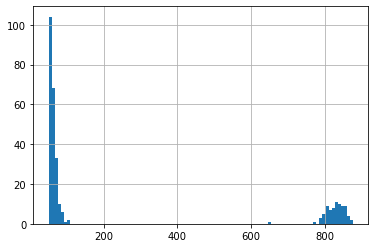

In [109]:
outliers_tavg["distance"].hist(bins = 100)

In [112]:
outliers_tavg[ outliers_tavg["distance"] > 500][ ["state_gazeeter", "state_station"] ].value_counts()

state_gazeeter  state_station
PR              FL               78
AK              AK                1
dtype: int64

In [113]:
outliers_tavg[ outliers_tavg["distance"] <= 500][ ["state_gazeeter", "state_station"] ].value_counts()

state_gazeeter  state_station
TX              TX               30
KS              KS               18
IA              IA               13
MN              MN               10
IL              IL               10
NE              NE                9
LA              LA                8
SD              SD                8
IL              IN                7
OK              OK                6
MN              SD                6
AR              AR                6
PA              PA                5
NY              NY                5
NM              NM                5
MI              MI                4
IN              IN                4
MO              MO                3
FL              FL                3
CO              CO                3
LA              MS                3
ME              ME                3
WI              WI                3
WV              WV                3
AK              AK                3
KS              OK                2
AR              MS                

In [110]:
for k, v in closest_stations_allinfo.items():
    ddiff = v[ v["state_gazeeter"] != v["state_station"]][ ["state_gazeeter", "state_station"]]
    print(k, len(ddiff ), len(v) )
    print( ddiff.value_counts() )

PRCP 69 3221
state_gazeeter  state_station
KY              TN               7
TX              OK               3
OK              KS               3
WV              OH               2
GA              AL               2
IN              KY               2
LA              MS               2
OK              AR               2
MO              AR               2
KY              IN               2
AR              MS               2
TX              LA               2
IL              MO               2
                KY               1
KY              OH               1
                IL               1
KS              NE               1
GA              TN               1
IL              IN               1
ID              OR               1
IA              MN               1
GA              FL               1
FL              AL               1
DC              VA               1
AZ              CA               1
AL              MS               1
KY              VA               1
MN          

In [103]:
closest_stations_allinfo["PRCP"]

,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
0,1001,Autauga County,AL,USC00010823,BILLINGSLEY,AL,32.6625,-86.7244,8.110800
1,1003,Baldwin County,AL,US1ALBW0079,DAPHNE 4.9 SE,AL,30.5724,-87.8444,6.740569
2,1005,Barbour County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,8.469317
3,1011,Bullock County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,13.711696
4,1109,Pike County,AL,US1ALBR0006,CLAYTON 7.8 W,AL,31.8826,-85.5839,17.527742
...,...,...,...,...,...,...,...,...,...
3216,72129,San Lorenzo Municipio,PR,RQ1PRJN0001,JUNCOS 0.3 WSW,PR,18.2228,-65.9161,5.270352
3217,72151,Yabucoa Municipio,PR,RQ1PRJN0001,JUNCOS 0.3 WSW,PR,18.2228,-65.9161,9.533835
3218,72097,Mayagüez Municipio,PR,RQ1PRRN0003,RINCON 1.5 N,PR,18.3627,-67.2497,37.022483
3219,72117,Rincón Municipio,PR,RQ1PRRN0003,RINCON 1.5 N,PR,18.3627,-67.2497,1.319982


# Filter out wrongly matched fips

In [113]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 100 ][ ["state_gazeeter", "state_station"]].value_counts()

state_gazeeter  state_station
PR              FL               234
AK              AK                20
LA              MS                 6
HI              AK                 6
                CA                 4
LA              LA                 3
ME              ME                 1
LA              TX                 1
                AL                 1
AZ              NM                 1
dtype: int64

In [114]:
dfmi_closest_stations[ (dfmi_closest_stations["distance"] > 100 )  & (dfmi_closest_stations["state_gazeeter"] == "AK")]

fips                      county state_gazeeter   station_id  \
SNOW 93   2013      Aleutians East Borough             AK  USC00502587   
     94   2016  Aleutians West Census Area             AK  USC00502587   
     99   2050          Bethel Census Area             AK  USC00507570   
     100  2060         Bristol Bay Borough             AK  USC00507570   
     101  2070      Dillingham Census Area             AK  USC00507570   
     102  2150       Kodiak Island Borough             AK  USC00507570   
     103  2158        Kusilvak Census Area             AK  USC00507570   
     104  2164  Lake and Peninsula Borough             AK  USC00507570   
     116  2180            Nome Census Area             AK  USW00026529   
     117  2188    Northwest Arctic Borough             AK  USW00026529   
     125  2282    Yakutat City and Borough             AK  USC00503504   
SNWD 89   2013      Aleutians East Borough             AK  USC00502587   
     90   2016  Aleutians West Census Area             AK  USC00502587   
     95   2050          Bethel Census Area             AK  USC00507570   
     97   2070      Dillingham Census Area             AK  USS0054K01S   
     110  2158        Kusilvak Census Area             AK  USS0064P01S   
PRCP 76   2016  Aleutians West Census Area             AK  USW00025711   
TMAX 78   2016  Aleutians West Census Area             AK  USW00025711   
TMIN 78   2016  Aleutians West Census Area             AK  USW00025711   
TAVG 112  2016  Aleutians West Census Area             AK  USW00025624   

                                          station_name state_station  \
SNOW 93   DUTCH HARBOR                                            AK   
     94   DUTCH HARBOR                                            AK   
     99   PORT ALSWORTH                                           AK   
     100  PORT ALSWORTH                                           AK   
     101  PORT ALSWORTH                                           AK   
     102  PORT ALSWORTH                                           AK   
     103  PORT ALSWORTH                                           AK   
     104  PORT ALSWORTH                                           AK   
     116  TANANA CALHOUN MEM AP                  70178            AK   
     117  TANANA CALHOUN MEM AP                  70178            AK   
     125  HAINES 40NW                                             AK   
SNWD 89   DUTCH HARBOR                                            AK   
     90   DUTCH HARBOR                                            AK   
     95   PORT ALSWORTH                                           AK   
     97   Mcneil River SGS                                        AK   
     110  Johnson's Camp                                          AK   
PRCP 76   ST. PAUL 4 NE                          70309            AK   
TMAX 78   ST. PAUL 4 NE                          70309            AK   
TMIN 78   ST. PAUL 4 NE                          70309            AK   
TAVG 112  COLD BAY AP                    GSN     70316            AK   

          latitude_station  longitude_station    distance  
SNOW 93            53.8950          -166.5433  164.577009  
     94            53.8950          -166.5433  516.924429  
     99            60.2036          -154.3164  164.415750  
     100           60.2036          -154.3164  110.477210  
     101           60.2036          -154.3164  116.174869  
     102           60.2036          -154.3164  139.416398  
     103           60.2036          -154.3164  263.729291  
     104           60.2036          -154.3164  130.908558  
     116           65.1744          -152.1069  284.497727  
     117           65.1744          -152.1069  205.127868  
     125           59.4503          -136.3614  117.916667  
SNWD 89            53.8950          -166.5433  164.577009  
     90            53.8950          -166.5433  516.924429  
     95            60.2036          -154.3164  164.415750  
     97            59.0800          -154.2

In [127]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 200 ][ ["state_gazeeter", "state_station"]].value_counts()

state_gazeeter  state_station
PR              FL               234
AK              AK                 9
HI              AK                 6
                CA                 4
dtype: int64

In [124]:
dfmi_closest_stations[ dfmi_closest_stations["distance"] > 200 ][ ["state_gazeeter", "state_station"]].value_counts().index.values

array([('PR', 'FL'), ('AK', 'AK'), ('HI', 'AK'), ('HI', 'CA')],
      dtype=object)

In [128]:
dfmi_closest_stations[ (dfmi_closest_stations["state_gazeeter"] == "HI" ) & (dfmi_closest_stations["state_station"] == "CA")]

fips         county state_gazeeter   station_id  \
SNOW 262  15001  Hawaii County             HI  US1CASM0007   
     263  15009    Maui County             HI  US1CASM0007   
SNWD 257  15001  Hawaii County             HI  US1CASM0007   
     258  15009    Maui County             HI  US1CASM0007   

                                          station_name state_station  \
SNOW 262  HALF MOON BAY 0.5 SSW                                   CA   
     263  HALF MOON BAY 0.5 SSW                                   CA   
SNWD 257  HALF MOON BAY 0.5 SSW                                   CA   
     258  HALF MOON BAY 0.5 SSW                                   CA   

          latitude_station  longitude_station     distance  
SNOW 262            37.463          -122.4408  1880.790043  
     263            37.463          -122.4408  1883.043157  
SNWD 257            37.463          -122.4408  1880.790043  
     258            37.463          -122.4408  1883.043157

In [138]:
a =dfmi_closest_stations.xs("SNOW")
print( a[a["state_gazeeter"] == "PR"]["distance"].min() )
a[a["state_gazeeter"] == "PR"]

770.3097769505598


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
425,72001,Adjuntas Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,816.178941
426,72003,Aguada Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,791.410175
427,72005,Aguadilla Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,790.049157
428,72007,Aguas Buenas Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,841.812683
429,72009,Aibonito Municipio,PR,USW00012839,MIAMI INTL AP 72202,FL,25.7906,-80.3164,839.538138
...,...,...,...,...,...,...,...,...,...
3216,72137,Toa Baja Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,832.876833
3217,72139,Trujillo Alto Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,844.937180
3218,72143,Vega Alta Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,827.184769
3219,72145,Vega Baja Municipio,PR,USW00012849,FT LAUDERDALE HOLLYWOOD AP 74783,FL,26.0719,-80.1536,823.898743


In [139]:
a =dfmi_closest_stations.xs("SNWD")
print( a[a["state_gazeeter"] == "PR"]["distance"].min() )
a[a["state_gazeeter"] == "PR"]

774.4266626683777


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
380,72021,Bayamón Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,846.445431
381,72029,Canóvanas Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,859.414382
382,72031,Carolina Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,853.722303
383,72033,Cataño Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,844.350263
384,72037,Ceiba Municipio,PR,US1FLPB0106,SANDALFOOT COVE 0.8 NW,FL,26.3467,-80.1979,873.432979
...,...,...,...,...,...,...,...,...,...
498,72133,Santa Isabel Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,846.800189
499,72141,Utuado Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,823.702407
500,72149,Villalba Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,838.128486
501,72151,Yabucoa Municipio,PR,USW00012896,MARATHON AP,FL,24.7258,-81.0517,868.517927


## Set snow and snow depth stations to NaN for Hawaii (HI) and Puerto Rico (PR)

In [187]:
print(dfmi_closest_stations.columns)
cols_to_nan = ['station_id', 'station_name','state_station', 'latitude_station', 'longitude_station', 'distance']
states_to_nan= ["HI", "PR"]
meas_to_nan = ["SNOW", "SNWD"]
# true for index where measure = SNOW or SNWD
cond_measure = dfmi_closest_stations.index.get_level_values(0).isin(meas_to_nan)
# true for state_station is HI or PR
cond_state = dfmi_closest_stations["state_gazeeter"].isin (states_to_nan)
# set rows where both conditions are true to nan
#print(dfmi_closest_stations[ cond_measure & cond_state])
dfmi_closest_stations.loc[ cond_measure & cond_state, cols_to_nan] = np.nan

Index(['fips', 'county', 'state_gazeeter', 'station_id', 'station_name',
       'state_station', 'latitude_station', 'longitude_station', 'distance'],
      dtype='object')


In [186]:
 dfmi_closest_stations.loc[cond_measure & cond_state] 


fips                  county state_gazeeter station_id  \
SNOW 95   15003         Honolulu County             HI        NaN   
     96   15005          Kalawao County             HI        NaN   
     97   15007            Kauai County             HI        NaN   
     262  15001           Hawaii County             HI        NaN   
     263  15009             Maui County             HI        NaN   
...         ...                     ...            ...        ...   
SNWD 498  72133  Santa Isabel Municipio             PR        NaN   
     499  72141        Utuado Municipio             PR        NaN   
     500  72149      Villalba Municipio             PR        NaN   
     501  72151       Yabucoa Municipio             PR        NaN   
     502  72153         Yauco Municipio             PR        NaN   

         station_name state_station  latitude_station  longitude_station  \
SNOW 95           NaN           NaN               NaN                NaN   
     96           NaN           NaN               NaN                NaN   
     97           NaN           NaN               NaN                NaN   
     262          NaN           NaN               NaN                NaN   
     263          NaN           NaN               NaN                NaN   
...               ...           ...               ...                ...   
SNWD 498          NaN           NaN               NaN                NaN   
     499          NaN           NaN               NaN                NaN   
     500          NaN           NaN               NaN                NaN   
     501          NaN           NaN               NaN                NaN   
     502          NaN           NaN               NaN                NaN   

          distance  
SNOW 95        NaN  
     96        NaN  
     97        NaN  
     262       NaN  
     263       NaN  
...            ...  
SNWD 498       NaN  
     499       NaN  
     500       NaN  
     501       NaN  
     502       NaN  

[166 rows x 9 columns]